In [1]:
import numpy as np
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()
cov_matrix = np.cov(data.data.T)  
eigenvalues, _ = np.linalg.eig(cov_matrix)
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [1.28248501e+06 1.45311939e+02 1.06832301e+02 8.26485165e+00
 6.57888123e+00 2.97385061e+00 3.04298498e-02 2.49931609e-01]


PCA Eigenvalues: [2.02522874 1.87236793]
Naive Bayes Accuracy (PCA features): 0.54


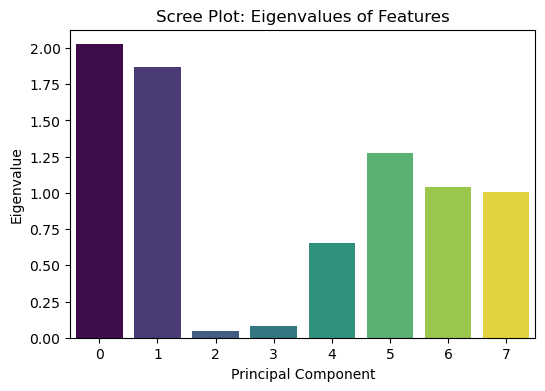

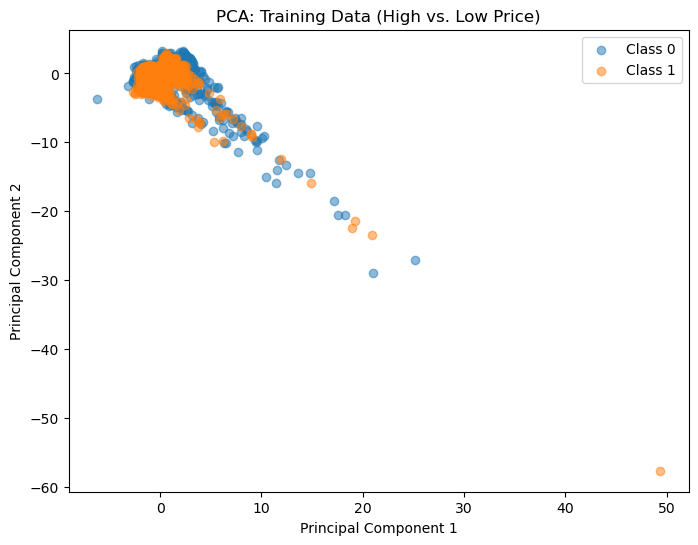

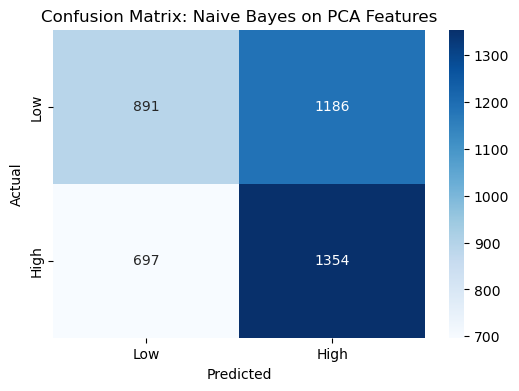

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and prepare dataset (like PHP/MyAdmin tables)
data = fetch_california_housing()  # 20640 samples, 8 features
df = pd.DataFrame(data.data, columns=data.feature_names)
df['PriceClass'] = (data.target > np.median(data.target)).astype(int)  # 1=high, 0=low

# Step 2: Split data
X = df.drop('PriceClass', axis=1)
y = df['PriceClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: PCA Implementation (Day 6 eigenvalues)
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.eigenvalues = None
    
    def fit(self, X):
        # Standardize (Day 4 stats)
        self.mean = np.mean(X, axis=0)
        X_std = StandardScaler().fit_transform(X)
        
        # Covariance matrix (Day 4)
        cov_matrix = np.cov(X_std.T)
        
        # Eigen decomposition (Day 6)
        eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
        self.eigenvalues = eigenvalues
        # Sort by eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Select top n_components
        self.components = eigenvectors[:, :self.n_components]
        return self
    
    def transform(self, X):
        X_std = StandardScaler().fit_transform(X)
        return X_std @ self.components

# Apply PCA
pca = PCA(n_components=2)
pca.fit(X_train.to_numpy())
X_train_pca = pca.transform(X_train.to_numpy())
X_test_pca = pca.transform(X_test.to_numpy())
print(f"PCA Eigenvalues: {pca.eigenvalues[:2]}")

# Step 4: Naive Bayes Classifier (Day 5)
class NaiveBayes:
    def __init__(self):
        self.class_priors = {}
        self.means = {}
        self.stds = {}
        self.epsilon = 1e-9
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        for c in self.classes:
            X_c = X[y == c]
            self.class_priors[c] = len(X_c) / len(X)
            self.means[c] = np.mean(X_c, axis=0)
            self.stds[c] = np.std(X_c, axis=0, ddof=1)
    
    def gaussian_pdf(self, x, mean, std):
        std = np.maximum(std, self.epsilon)
        exponent = -((x - mean) ** 2) / (2 * std ** 2)
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(exponent)
    
    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.class_priors[c])
                likelihood = np.sum(np.log(self.gaussian_pdf(x, self.means[c], self.stds[c]) + self.epsilon))
                posterior = prior + likelihood
                posteriors.append(posterior)
            predictions.append(self.classes[np.argmax(posteriors)])
        return np.array(predictions)

# Train and evaluate Naive Bayes on PCA features
nb = NaiveBayes()
nb.fit(X_train_pca, y_train.to_numpy())
y_pred = nb.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy (PCA features): {accuracy:.2f}")

# Step 5: Visualizations (display only, no saving)
# Scree Plot for Eigenvalues
plt.figure(figsize=(6, 4))
sns.barplot(x=np.arange(len(pca.eigenvalues)), y=pca.eigenvalues, hue=np.arange(len(pca.eigenvalues)), palette='viridis', legend=False)
plt.title('Scree Plot: Eigenvalues of Features')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()

# PCA Scatter Plot
plt.figure(figsize=(8, 6))
for cls in [0, 1]:
    mask = y_train == cls
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=f'Class {cls}', alpha=0.5)
plt.title('PCA: Training Data (High vs. Low Price)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title('Confusion Matrix: Naive Bayes on PCA Features')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()